In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import seaborn as sns

%matplotlib inline

In [20]:
df = pd.read_csv('./datasets/others/merge-date.csv')

In [21]:
df["date"] = pd.to_datetime(df["date"])
df_per_zipcode = dict(tuple(df.groupby('PC4')))

In [22]:
df_pc = df_per_zipcode[5612]
df_pc

,date,PC4,pm10,pm2.5,no2,no,so2,wd,ws,blh,tcc,ssrd,pop_tot,m00_30,m30_60,H1_2,H2_4,H4_8,H8_16,H16plus
1320,2021-09-25 00:00:00,5612,7.864758,4.531495,26.565818,17.380828,2.309348,230.133057,3.541795,294.448578,0.904267,0.0,1321,35.0,0.0,0.0,53.0,53.0,141.0,1039.0
1321,2021-09-25 01:00:00,5612,5.563095,3.425978,16.819145,11.004015,2.149709,231.140366,3.539907,284.883392,0.939340,0.0,1331,62.0,0.0,0.0,62.0,42.0,166.0,999.0
1322,2021-09-25 02:00:00,5612,6.333280,4.198472,17.503193,11.451557,1.985016,230.401825,3.368636,263.266968,0.956759,0.0,1459,73.0,0.0,0.0,55.0,55.0,128.0,1148.0
1323,2021-09-25 03:00:00,5612,7.906101,5.428337,17.364577,11.360867,2.035825,229.915527,3.196347,250.996796,0.972057,0.0,1481,53.0,0.0,0.0,53.0,71.0,176.0,1128.0
1324,2021-09-25 04:00:00,5612,10.083385,6.628572,17.365165,11.361251,2.248151,230.417725,3.158529,252.089752,0.978106,0.0,1723,126.0,21.0,21.0,21.0,126.0,168.0,1240.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2635,2021-11-18 19:00:00,5612,26.669399,11.933744,40.996352,26.822081,4.719248,209.939117,4.576016,531.687439,1.000000,0.0,2980,355.0,42.0,188.0,335.0,261.0,617.0,1182.0
2636,2021-11-18 20:00:00,5612,21.074810,13.009178,44.324627,28.999623,5.337728,210.107040,4.497765,508.846771,1.000000,0.0,2416,200.0,21.0,105.0,232.0,232.0,538.0,1088.0
2637,2021-11-18 21:00:00,5612,23.398365,14.110627,45.162388,29.547733,5.818445,214.289536,4.513569,463.560822,1.000000,0.0,2370,206.0,52.0,52.0,196.0,185.0,392.0,1287.0
2638,2021-11-18 22:00:00,5612,31.509649,16.648342,46.849234,30.651361,6.312644,209.946259,4.689488,434.309601,1.000000,0.0,1785,133.0,20.0,41.0,71.0,82.0,224.0,1214.0


In [23]:
df_pc_pm2_5 = df_pc[['date','pm2.5']]


def make_lags(df_pc_pm2_5, lags, lead_time=1):
    return pd.concat(
        {
            f'y_lag_{i}': df_pc_pm2_5.shift(i)
            for i in range(lead_time, lags + lead_time)
        },
        axis=1)

y = df_pc_pm2_5['pm2.5'].copy()
X = make_lags(y, lags=4).fillna(0.0)

def make_multistep_target(df_pc_pm2_5, steps):
    return pd.concat(
        {f'y_step_{i + 1}': df_pc_pm2_5.shift(-i)
         for i in range(steps)},
        axis=1)

In [24]:
y = make_multistep_target(y, steps=8).dropna()
y, X = y.align(X, join='inner', axis=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

model = LinearRegression()
model.fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y.columns)
y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

Train RMSE: 4.43
Test RMSE: 7.85


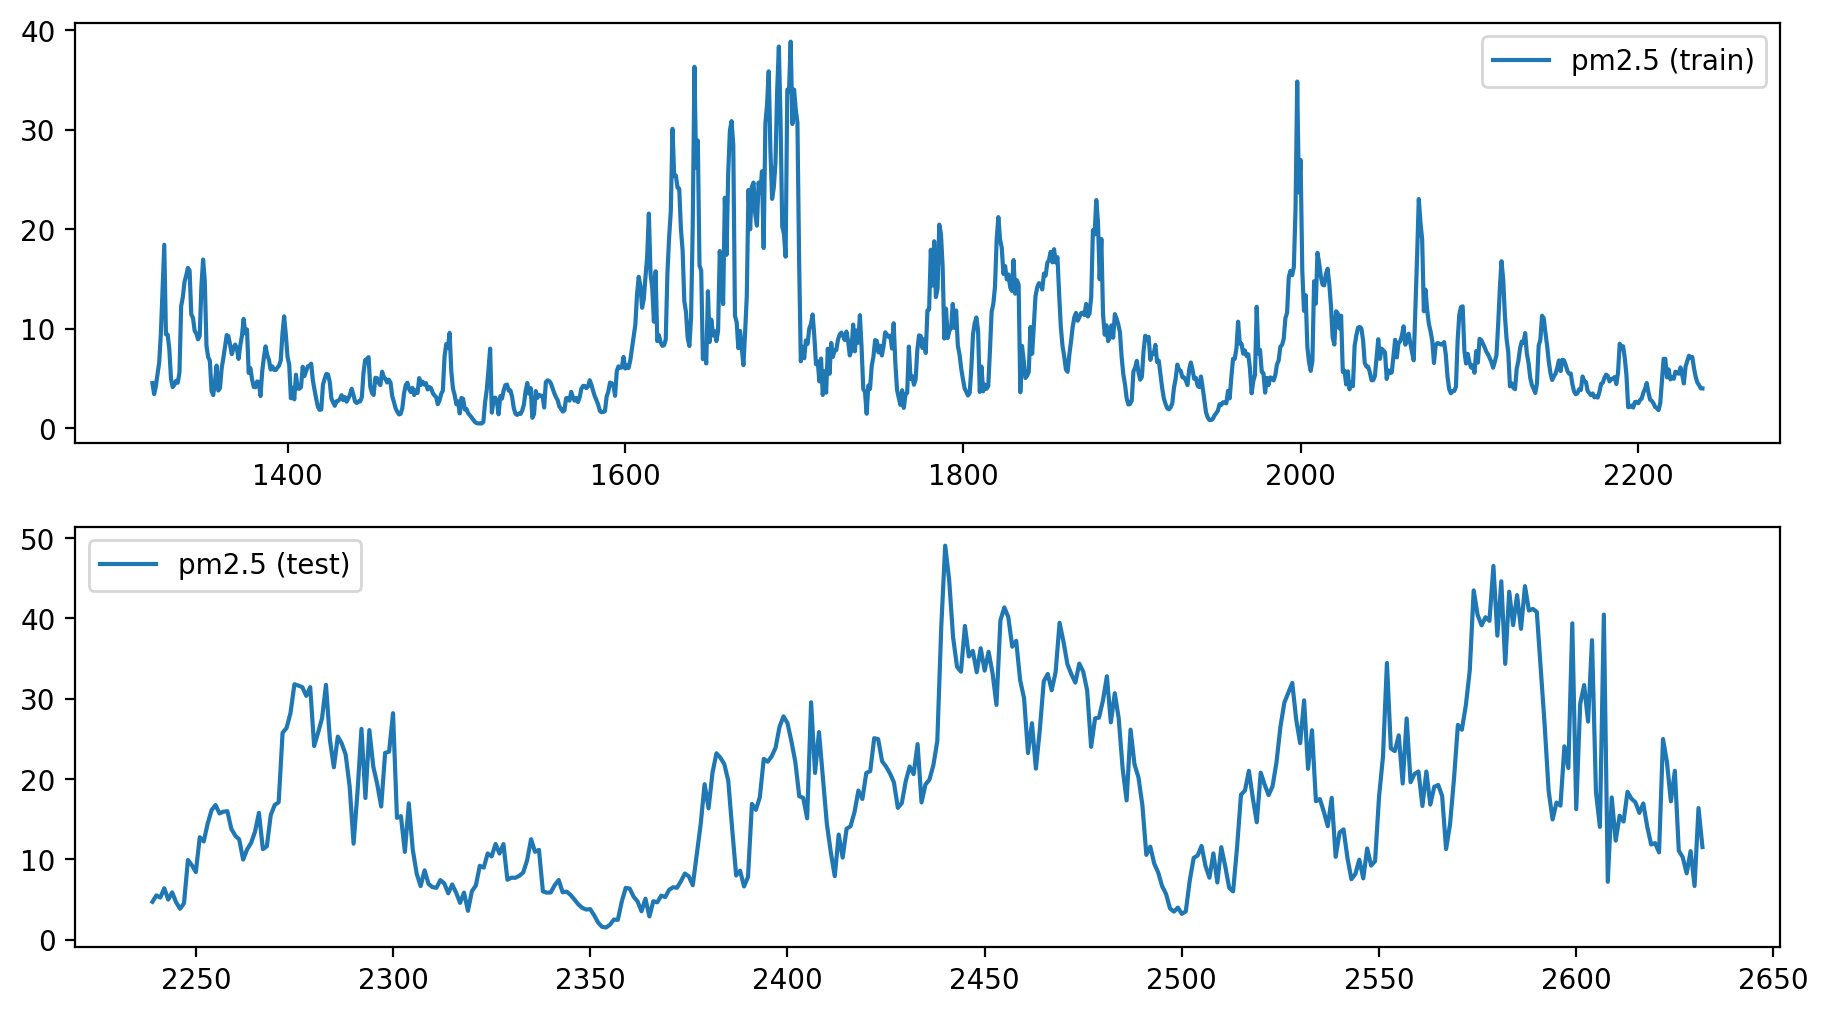

In [26]:
train_rmse = mean_squared_error(y_train, y_fit, squared=False)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print((f"Train RMSE: {train_rmse:.2f}\n" f"Test RMSE: {test_rmse:.2f}"))

palette = dict(palette='husl', n_colors=64)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 6))

ax1 = df_pc_pm2_5['pm2.5'][y_fit.index].plot(ax=ax1)
# ax1 = plot_multistep(y_fit, ax=ax1, palette_kwargs=palette)
_ = ax1.legend(['pm2.5 (train)', 'Forecast'])

ax2 = df_pc_pm2_5['pm2.5'][y_pred.index].plot(ax=ax2)
# ax2 = plot_multistep(y_pred, ax=ax2, palette_kwargs=palette)
_ = ax2.legend(['pm2.5 (test)', 'Forecast'])